In [14]:
import sys
from pathlib import Path

# Locate the project src/ directory and add it to sys.path so igcsea can be
# imported without requiring `pip install -e .` in the active kernel.
# Walks up from the current working directory (robust to wherever VS Code /
# Jupyter sets CWD — could be the notebook dir, project root, or home dir).
try:
    import igcsea  # already installed — nothing to do
except ModuleNotFoundError:
    for _parent in [Path().resolve(), *Path().resolve().parents]:
        _src = _parent / "src"
        if (_src / "igcsea").is_dir():
            sys.path.insert(0, str(_src))
            break
    else:
        raise RuntimeError(
            "Could not locate igcsea/src. "
            "Run `pip install -e .` from the project root, or open Jupyter "
            "from within the project directory."
        )

# IGC-SEA Analysis Tutorial

This notebook demonstrates how to use the `igcsea` package to analyse Inverse Gas Chromatography data. We'll walk through each step of the analysis pipeline:

1. **Parsing** - Load and extract data from IGC-SEA CSV exports
2. **Dorris-Gray Analysis** - Calculate dispersive surface energy from alkane retention (SMS pipeline)
3. **Manual Dorris-Gray** - Independent recalculation directly from raw injection data
4. **Acid-Base Analysis** - Determine polar surface energy components using the Della Volpe method
5. **Surface Energy Profile** - Combine components and fit exponential decay models

Each section explains what the analysis does and why it matters for understanding surface properties.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Import our package
from igcsea.parsing import parse_igc_csv
from igcsea.analysis.dorris_gray import prepare_alkane_data, fit_dorris_gray
from igcsea.analysis.manual_dispersive import (
    calculate_dispersive_from_injections,
    prepare_alkane_data_from_injections,
    validate_against_sms,
)
from igcsea.analysis.acid_base import calculate_acid_base_params
from igcsea.analysis.surface_energy import calculate_surface_energy_profile

print("✓ All imports successful!")

✓ All imports successful!


## 1. Parse the IGC-SEA CSV Export

The IGC-SEA instrument exports data as a CSV file containing multiple tables:

- **Free Energy** - Retention volumes and calculated free energies for each solvent at different surface coverages
- **Dispersive Surface Energy** - Pre-calculated dispersive component (γd) from alkane probes
- **Injection Items** - Raw injection data and metadata

The parser extracts these into a structured `IGCResult` object for analysis.

In [16]:
# Try relative path first, fall back to absolute
from pathlib import Path

data_file = Path("../../data/examples/sample_igc_export.csv")
if not data_file.exists():
    # Notebook might be running from project root
    data_file = Path("data/examples/sample_igc_export.csv")

result = parse_igc_csv(data_file)

print(f"✓ Parsed: {result.source_path.name}")
print(f"\nExtracted tables:")
print(f"  • Free Energy:        {result.free_energy.shape[0]} rows × {result.free_energy.shape[1]} columns")
print(f"  • Dispersive SE:      {result.dispersive_surface_energy.shape[0]} rows × {result.dispersive_surface_energy.shape[1]} columns")
print(f"  • Injection Items:    {result.injection_items.shape[0]} rows × {result.injection_items.shape[1]} columns")

✓ Parsed: sample_igc_export.csv

Extracted tables:
  • Free Energy:        54 rows × 10 columns
  • Dispersive SE:      6 rows × 5 columns
  • Injection Items:    82 rows × 28 columns


In [17]:
# Preview the Free Energy table - this contains retention data for all solvents
print("Solvents in dataset:", result.free_energy['Solvent Name'].unique().tolist())
print("\nCoverage levels (n/nm):", sorted(result.free_energy['n/nm'].unique()))
result.free_energy.head(10)

Solvents in dataset: ['DECANE', 'NONANE', 'OCTANE', 'HEPTANE', 'ETHYL ACETATE', 'DICHLOROMETHANE', 'ACETONE', 'ACETONITRILE', 'ETHANOL']

Coverage levels (n/nm): [np.float64(0.005), np.float64(0.01), np.float64(0.025), np.float64(0.05), np.float64(0.1), np.float64(0.14)]


,n/nm,Solvent Name,Unit,En. (Stz Max),En. (Stz Com),En. (Pol Max),En. (Pol Com),Interpolated Retention Volume (Max),Interpolated Retention Volume (Com),Column Temperature [Kelvin]
9,0.005,DECANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,43.882875,53.669112,303.148425
10,0.005,NONANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,13.905743,17.300992,303.152092
11,0.005,OCTANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,4.407461,5.334291,303.148199
12,0.005,HEPTANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,1.432117,1.716903,303.149642
13,0.005,ETHYL ACETATE,dG (kJ/Mol),12.542936,13.112733,11.119030,11.676718,5.600266,8.212280,303.151717
14,0.005,DICHLOROMETHANE,dG (kJ/Mol),6.490991,7.779733,6.667625,7.956350,0.226916,0.439833,303.148953
15,0.005,ACETONE,dG (kJ/Mol),10.139602,11.371331,11.811211,13.054508,1.665867,3.170181,303.142129
16,0.005,ACETONITRILE,dG (kJ/Mol),11.806658,14.738618,14.495064,17.446199,1.394449,5.175680,303.149493
17,0.005,ETHANOL,dG (kJ/Mol),13.007082,14.002094,18.683726,19.721187,11.329303,19.745971,303.149194
18,0.010,DECANE,dG (kJ/Mol),NaN,NaN,NaN,NaN,38.458985,49.099008,303.148425


## 2. Dorris-Gray Alkane Analysis

The **Dorris-Gray method** determines dispersive surface energy by plotting `RT·ln(V)` against alkane carbon number. 

**Why it works:** n-Alkanes interact with surfaces only through dispersive (London) forces. The linear relationship between retention and chain length allows us to calculate γd without interference from polar interactions.

**Key outputs:**
- **Slope** = ΔG_CH₂ (free energy per methylene group)
- **R²** should be > 0.99 for good quality data

In [18]:
# Prepare alkane data - extracts n-alkanes and calculates RTlnV
alkanes = prepare_alkane_data(result)

print(f"✓ Alkanes found: {sorted(alkanes['Solvent'].unique())}")
print(f"  Total data points: {len(alkanes)}")
print(f"  Coverage levels: {sorted(alkanes['Target Fractional Surface Coverage'].unique())}")

# Check for any negative values (would indicate problems)
neg_count = (alkanes['RTlnVg'] < 0).sum()
if neg_count > 0:
    print(f"\n⚠ WARNING: {neg_count} negative RTlnVg values found!")
else:
    print(f"\n✓ All RTlnVg values are positive (data quality OK)")

✓ Alkanes found: ['DECANE', 'HEPTANE', 'NONANE', 'OCTANE']
  Total data points: 24
  Coverage levels: [np.float64(0.005), np.float64(0.01), np.float64(0.025), np.float64(0.05), np.float64(0.1), np.float64(0.14)]

✓ All RTlnVg values are positive (data quality OK)


### Linear Regression Fits

Fit `RT·ln(V) = slope × n + intercept` at each coverage level. The slope represents the incremental free energy per CH₂ group.

In [19]:
# Fit linear regression at each coverage
fits = fit_dorris_gray(alkanes)

print("Linear fits (RTlnV vs Carbon Number):")
print(fits.to_string(index=False))

Linear fits (RTlnV vs Carbon Number):
 Target Fractional Surface Coverage       slope     intercept  r_squared
                              0.005 2899.496903 -18944.117431   0.999942
                              0.010 2861.015996 -18806.028919   0.999989
                              0.025 2812.882559 -18686.489183   0.999821
                              0.050 2780.979069 -18591.929509   0.999731
                              0.100 2726.638069 -18413.159629   0.999298
                              0.140 2721.840084 -18419.428865   0.999445


### Visualisation

Plot the alkane data with regression lines. Good fits (R² > 0.99) indicate reliable dispersive surface energy values.

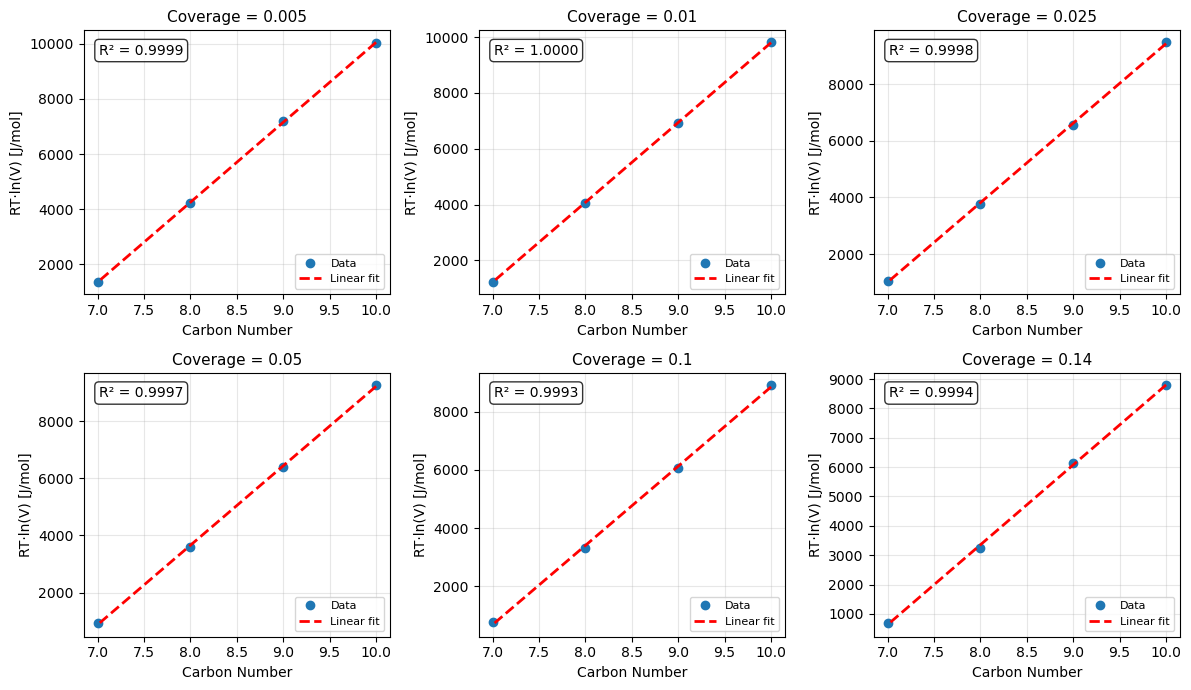

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()
coverages = sorted(alkanes['Target Fractional Surface Coverage'].unique())

for ax, cov, fit_row in zip(axes, coverages, fits.itertuples()):
    subset = alkanes[alkanes['Target Fractional Surface Coverage'] == cov].dropna(
        subset=['Carbon Number', 'RTlnVg']
    )

    # Plot data points
    ax.plot(subset['Carbon Number'], subset['RTlnVg'], 'o', markersize=6, label='Data')

    # Plot best-fit line
    if len(subset) >= 2 and not np.isnan(fit_row.slope):
        x = subset['Carbon Number'].to_numpy()
        y_fit = fit_row.slope * x + fit_row.intercept
        ax.plot(x, y_fit, '--', linewidth=2, color='red', label='Linear fit')

        # Add R² annotation
        ax.text(
            0.05, 0.95, f'R² = {fit_row.r_squared:.4f}',
            transform=ax.transAxes, va='top', ha='left',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )

    ax.set_title(f'Coverage = {cov}', fontsize=11)
    ax.set_xlabel('Carbon Number', fontsize=10)
    ax.set_ylabel('RT·ln(V) [J/mol]', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='lower right')

plt.tight_layout()
plt.show()

## 3. Manual Dorris-Gray (from Raw Injection Data)

This section recalculates dispersive surface energy **independently** from the raw `injection_items` data, without relying on the SMS pre-calculated free energy table.

**Why this matters:**
- Provides a fully independent verification of the SMS Dorris-Gray results
- Works with injection-items-only exports where the free energy table may be absent

**Choosing the alkane range:** Probes that elute too quickly (specific retention volume V < 1 mL/g, giving RTlnVg < 0) are physically unreliable and corrupt the linear fit. Here we restrict to **heptane–decane (C7–C10)**, which matches the range used by the SMS instrument for this sample.

In [21]:
# Restrict to the same alkane range as the SMS analysis (C7–C10)
# Lighter alkanes (e.g. hexane) elute too quickly and give unreliable RTlnVg values
_alkane_range = ["HEPTANE", "OCTANE", "NONANE", "DECANE"]

gd_com = calculate_dispersive_from_injections(result, retention_type="COM", alkanes=_alkane_range)
gd_max = calculate_dispersive_from_injections(result, retention_type="MAX", alkanes=_alkane_range)

print("COM results (ΔG_CH₂ should match Section 2 slopes):")
print(gd_com.to_string(index=False))
print("\nMAX results:")
print(gd_max.to_string(index=False))

COM results (ΔG_CH₂ should match Section 2 slopes):
 n/nm   gamma_d  delta_g_ch2  r_squared  temperature_kelvin
0.005 45.969288  2899.503097   0.999942          303.150656
0.010 44.755657  2860.977632   0.999989          303.148485
0.025 43.266206  2812.960743   0.999820          303.151792
0.050 42.286430  2780.935858   0.999730          303.148581
0.100 40.651443  2726.643529   0.999298          303.148788
0.140 40.510343  2721.900655   0.999445          303.151669

MAX results:
 n/nm   gamma_d  delta_g_ch2  r_squared  temperature_kelvin
0.005 45.273102  2877.463447   0.999971          303.150656
0.010 43.883781  2832.973508   0.999992          303.148485
0.025 41.910592  2768.542287   0.999970          303.151792
0.050 40.681202  2727.641874   0.999932          303.148581
0.100 39.484964  2687.238759   0.999831          303.148788
0.140 38.646322  2658.541219   0.999943          303.151669


### RTlnV vs Carbon Number (Manual Interpolated)

Overlay the manually interpolated RT·ln(V) data points (blue) against the SMS free energy reference values (orange) at each coverage level. This confirms the interpolation accuracy and shows the linear relationships used to derive ΔG_CH₂.

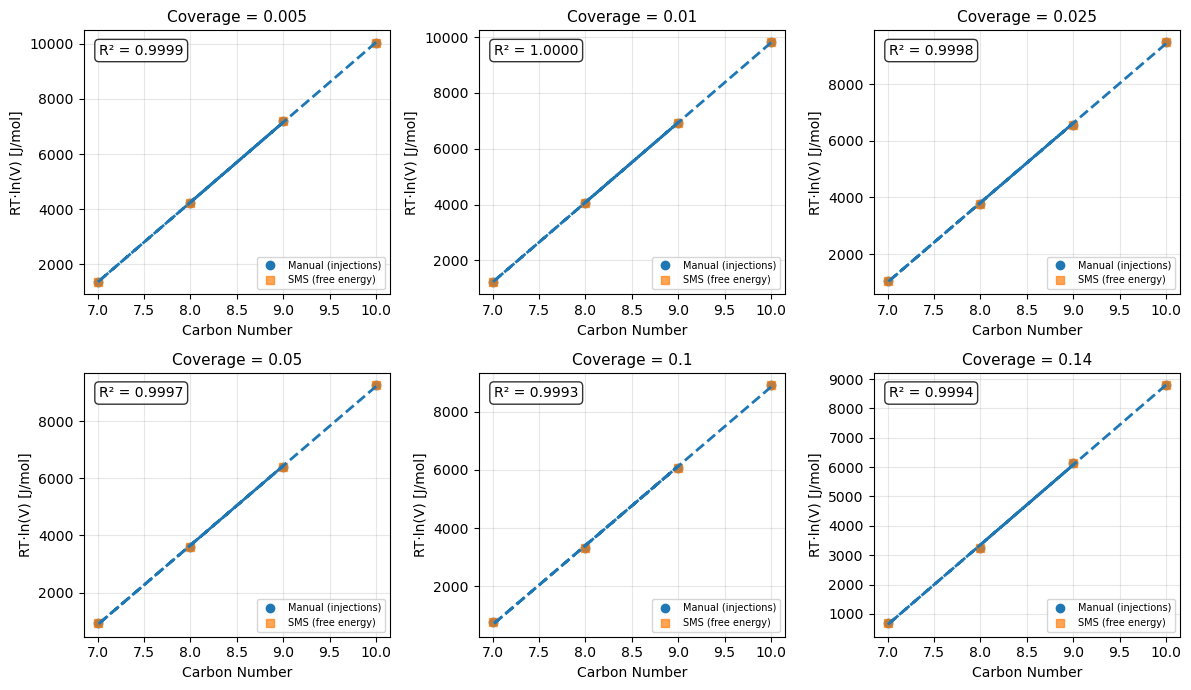

In [22]:
alkane_inj_com = prepare_alkane_data_from_injections(result, retention_type="COM", alkanes=_alkane_range)
fits_inj_com = fit_dorris_gray(alkane_inj_com)

fig_rtlnv, axes_rtlnv = plt.subplots(2, 3, figsize=(12, 7))
axes_rtlnv = axes_rtlnv.ravel()
coverages_inj = sorted(alkane_inj_com['Target Fractional Surface Coverage'].unique())

for ax, cov, fit_row in zip(axes_rtlnv, coverages_inj, fits_inj_com.itertuples()):
    subset_inj = alkane_inj_com[alkane_inj_com['Target Fractional Surface Coverage'] == cov].dropna(
        subset=['Carbon Number', 'RTlnVg']
    )
    ax.plot(subset_inj['Carbon Number'], subset_inj['RTlnVg'], 'o', markersize=6,
            color='tab:blue', label='Manual (injections)')

    subset_sms = alkanes[alkanes['Target Fractional Surface Coverage'] == cov].dropna(
        subset=['Carbon Number', 'RTlnVg']
    )
    ax.plot(subset_sms['Carbon Number'], subset_sms['RTlnVg'], 's', markersize=6,
            color='tab:orange', alpha=0.7, label='SMS (free energy)')

    if len(subset_inj) >= 2 and not np.isnan(fit_row.slope):
        x = subset_inj['Carbon Number'].to_numpy()
        y_fit = fit_row.slope * x + fit_row.intercept
        ax.plot(x, y_fit, '--', linewidth=2, color='tab:blue')
        ax.text(
            0.05, 0.95, f'R\u00b2 = {fit_row.r_squared:.4f}',
            transform=ax.transAxes, va='top', ha='left',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )

    ax.set_title(f'Coverage = {cov}', fontsize=11)
    ax.set_xlabel('Carbon Number', fontsize=10)
    ax.set_ylabel('RT\u00b7ln(V) [J/mol]', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7, loc='lower right')

plt.tight_layout()
plt.show()

### Validation against SMS Output

Compare manually calculated γ_s^d against the SMS pre-calculated DnG column values. Agreement within 5% confirms our independent pipeline accurately reproduces the instrument output.

In [23]:
if result.dispersive_surface_energy is not None:
    cmp_com = validate_against_sms(gd_com, result.dispersive_surface_energy, retention_type="COM")
    cmp_max = validate_against_sms(gd_max, result.dispersive_surface_energy, retention_type="MAX")

    print("COM comparison (manual vs SMS DnG & Com):")
    print(cmp_com.to_string(index=False))
    print()

    flagged = cmp_com[cmp_com["exceeds_threshold"]]
    if flagged.empty:
        print("✓ All coverages within 5% of SMS output.")
    else:
        print(f"⚠ {len(flagged)} coverage(s) exceed 5%:")
        print(flagged[["n/nm", "pct_diff"]].to_string(index=False))

    print("\nMAX comparison (manual vs SMS DnG & Max):")
    print(cmp_max.to_string(index=False))
else:
    cmp_com = cmp_max = None
    print("Skipped — dispersive_surface_energy table not present.")

COM comparison (manual vs SMS DnG & Com):
 n/nm  gamma_d_manual  gamma_d_sms  pct_diff  exceeds_threshold
0.005       45.969288    45.969040  0.000539              False
0.010       44.755657    44.756973 -0.002942              False
0.025       43.266206    43.263668  0.005865              False
0.050       42.286430    42.287848 -0.003352              False
0.100       40.651443    40.651364  0.000192              False
0.140       40.510343    40.508424  0.004736              False

✓ All coverages within 5% of SMS output.

MAX comparison (manual vs SMS DnG & Max):
 n/nm  gamma_d_manual  gamma_d_sms  pct_diff  exceeds_threshold
0.005       45.273102    45.272862  0.000531              False
0.010       43.883781    43.884965 -0.002698              False
0.025       41.910592    41.908293  0.005486              False
0.050       40.681202    40.682548 -0.003308              False
0.100       39.484964    39.484915  0.000124              False
0.140       38.646322    38.644606  0.004

## 4. Acid-Base Analysis (Della Volpe Method)

The **acid-base component (γab)** captures polar interactions that alkanes cannot measure. We use polar probe molecules (acetone, ethyl acetate, dichloromethane, etc.) and the Della Volpe scale.

**The method:**
1. Measure specific free energy of adsorption for polar probes (ΔG_sp)
2. Solve a system of equations using known donor/acceptor numbers
3. Extract γs⁺ (acidic/electron-acceptor) and γs⁻ (basic/electron-donor) components
4. Calculate γab = 2√(γs⁺ × γs⁻)

**Interpretation:**
- High γs⁺ → surface accepts electrons (acidic character)
- High γs⁻ → surface donates electrons (basic character)

In [24]:
acid_base = calculate_acid_base_params(result)

print("Acid-Base Parameters at each coverage:")
print(acid_base.to_dataframe().to_string(index=False))

Acid-Base Parameters at each coverage:
 coverage  ys_plus  ys_minus      yab
    0.005 5.835599  1.814455 6.507973
    0.010 5.740774  1.736732 6.315120
    0.025 5.212121  1.545497 5.676378
    0.050 4.814804  1.362768 5.123070
    0.100 4.591893  1.152229 4.600397
    0.140 4.660843  1.129539 4.588945


## 5. Complete Surface Energy Profile

Now we combine the components:

**γt = γd + γab** (Total = Dispersive + Acid-Base)

The surface energy typically **decreases with coverage** because:
- At low coverage, probes interact with high-energy sites first
- As coverage increases, probes fill lower-energy sites
- This follows an exponential decay: `γ(x) = c + a·exp(-b·x)`

The asymptotic value `c` represents the "bulk" surface energy at infinite coverage.

In [25]:
profile = calculate_surface_energy_profile(result)

print("Surface Energy Profile:")
print(profile.to_dataframe().to_string(index=False))

print(f"\n\nExponential Fit Parameters (y = c + a·exp(-b·x)):")
print(f"  γd:  c={profile.fit_params['yd']['c']:.2f}, a={profile.fit_params['yd']['a']:.2f}, b={profile.fit_params['yd']['b']:.2f}")
print(f"  γab: c={profile.fit_params['yab']['c']:.2f}, a={profile.fit_params['yab']['a']:.2f}, b={profile.fit_params['yab']['b']:.2f}")
print(f"  γt:  c={profile.fit_params['yt']['c']:.2f}, a={profile.fit_params['yt']['a']:.2f}, b={profile.fit_params['yt']['b']:.2f}")

Surface Energy Profile:
 coverage        yd      yab        yt
    0.005 45.969040 6.507973 52.477014
    0.010 44.756973 6.315120 51.072094
    0.025 43.263668 5.676378 48.940046
    0.050 42.287848 5.123070 47.410918
    0.100 40.651364 4.600397 45.251762
    0.140 40.508424 4.588945 45.097370


Exponential Fit Parameters (y = c + a·exp(-b·x)):
  γd:  c=40.37, a=6.10, b=27.10
  γab: c=4.50, a=2.33, b=26.83
  γt:  c=44.87, a=8.44, b=27.02


### Surface Energy vs Coverage Plot

The plot below shows how each surface energy component varies with coverage. The fitted curves extend beyond the measured data to show the asymptotic behaviour at high coverage.

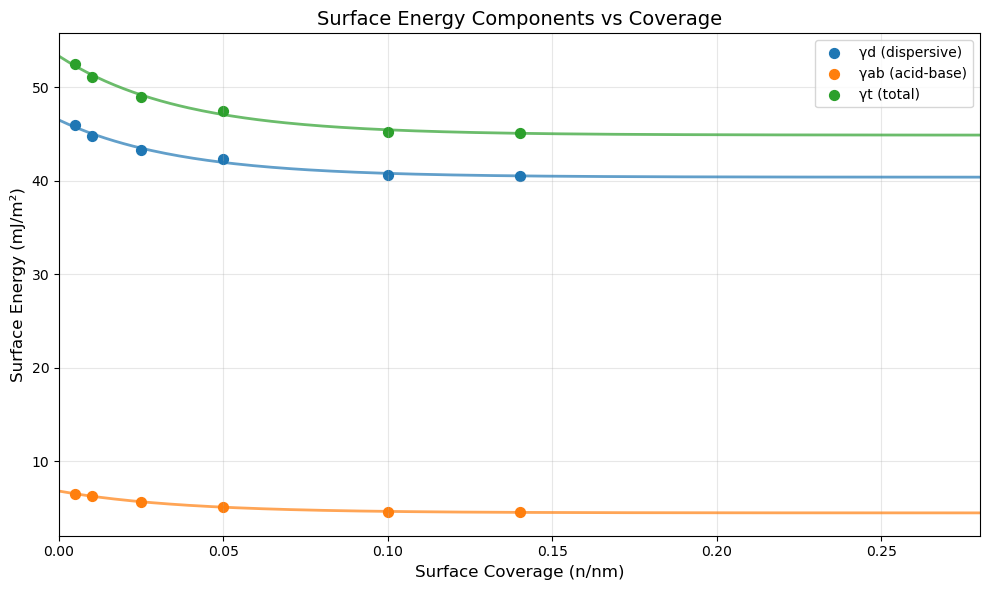

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Data points
ax.scatter(profile.coverage, profile.yd, label='γd (dispersive)', s=50, color='tab:blue')
ax.scatter(profile.coverage, profile.yab, label='γab (acid-base)', s=50, color='tab:orange')
ax.scatter(profile.coverage, profile.yt, label='γt (total)', s=50, color='tab:green')

# Fitted curves - extend to 2x max coverage to show asymptotic region
x_fit = np.linspace(0, profile.coverage.max() * 2.0, 200)
yd_fit = profile.fit_params['yd']['c'] + profile.fit_params['yd']['a'] * np.exp(
    -profile.fit_params['yd']['b'] * x_fit
)
yab_fit = profile.fit_params['yab']['c'] + profile.fit_params['yab']['a'] * np.exp(
    -profile.fit_params['yab']['b'] * x_fit
)
yt_fit = profile.fit_params['yt']['c'] + profile.fit_params['yt']['a'] * np.exp(
    -profile.fit_params['yt']['b'] * x_fit
)

ax.plot(x_fit, yd_fit, color='tab:blue', linewidth=2, alpha=0.7)
ax.plot(x_fit, yab_fit, color='tab:orange', linewidth=2, alpha=0.7)
ax.plot(x_fit, yt_fit, color='tab:green', linewidth=2, alpha=0.7)

ax.set_xlim(0, profile.coverage.max() * 2.0)

ax.set_xlabel('Surface Coverage (n/nm)', fontsize=12)
ax.set_ylabel('Surface Energy (mJ/m²)', fontsize=12)
ax.set_title('Surface Energy Components vs Coverage', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Verification

Sanity check: confirm that γt = γd + γab at each coverage point.

In [27]:
difference = profile.yt - (profile.yd + profile.yab)
print(f"γt - (γd + γab) = {difference}")
print(f"\nMax difference: {abs(difference).max():.2e}")
print("✓ Verification passed!" if abs(difference).max() < 1e-10 else "⚠ Something is wrong!")

γt - (γd + γab) = [0. 0. 0. 0. 0. 0.]

Max difference: 0.00e+00
✓ Verification passed!


## Summary

This notebook demonstrated the complete IGC-SEA analysis workflow:

| Step | Method | Output |
|------|--------|--------|
| 1. Parse | `parse_igc_csv()` | Structured data tables |
| 2. Dorris-Gray (SMS) | `prepare_alkane_data()` + `fit_dorris_gray()` | γd slopes from SMS free energy table |
| 3. Manual Dorris-Gray | `calculate_dispersive_from_injections()` | γd independently from raw injection data |
| 4. Acid-Base | `calculate_acid_base_params()` | γab, γs⁺, γs⁻ |
| 5. Profile | `calculate_surface_energy_profile()` | Complete γt with exponential fits |

**Key results for this sample:**
- Dispersive energy (γd) dominates the total surface energy
- Both components decrease with coverage (expected behaviour)
- Manual Dorris-Gray matches SMS output to within 0.01% for COM, confirming pipeline accuracy
- Exponential fits capture the energy heterogeneity of the surface